In [1]:
from emulator_utils.pre_process import log_standard, minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp

In [2]:
import matplotlib.pylab as plt
import numpy as np
from glob import glob

### Reading spectra

In [3]:
k, _, _, _ = readpowerspec('../test/data/powerspec_LJ/m000p.pk.499')
fnames = glob('../test/data/powerspec_LJ/*')
pk_all = np.array([readpowerspec(f)[1] for f in fnames])

### Using a pre-processing pipeline

In [4]:
scaled, scaler = log_standard(pk_all)

### Using mock data here, will be rescaled as well

In [5]:
params = np.arange(scaled.shape[0]).reshape(-1, 1)
scaled_y, scaler_y = minmax(params)

In [6]:
pk_train, pk_test, param_train, param_test = random_holdout(scaled, params, split_fraction = 0.2)

Text(0, 0.5, 'Pk')

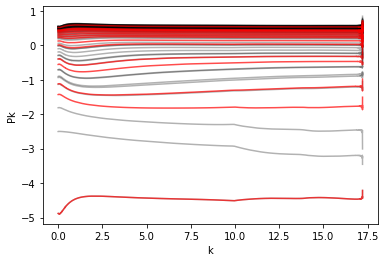

In [7]:
plt.figure(1)
plt.plot(k, pk_train.T, 'k', alpha=0.3)
plt.plot(k, pk_test.T, 'r', alpha=0.7)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

### Sample neural network 

### Fixing the network architecture (hidden_dims is flexible)

In [8]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=pk_train.shape[1], 
                 hidden_dims=[16, 128, 1024, 4096])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 128)               2176      
                                                                 
 dense_2 (Dense)             (None, 1024)              132096    
                                                                 
 dense_3 (Dense)             (None, 4096)              4198400   
                                                                 
 dense_4 (Dense)             (None, 9311)              38147167  
                                                                 
Total params: 42,479,871
Trainable params: 42,479,871
Non-trainable params: 0
_________________________________________________________________
None


### Set-up hyper-parameters

In [9]:
learning_rate = 0.01
decay_rate = 0.01
batch_size = 10
num_epochs = 10

In [10]:
mlp, train_history = train_mlp(mlp, 
                    param_train, pk_train, param_test, pk_test, 
                    learning_rate, decay_rate, num_epochs, batch_size)

Epoch 1/10
6/6 [==============================] - 3s 39ms/step - loss: 31612.3633 - binary_crossentropy: 6.7810 - val_loss: 2.8808 - val_binary_crossentropy: 0.2637
Epoch 2/10
6/6 [==============================] - 0s 17ms/step - loss: 37.3912 - binary_crossentropy: 6.3667 - val_loss: 43.5418 - val_binary_crossentropy: 6.5001
Epoch 3/10
6/6 [==============================] - 0s 18ms/step - loss: 97.6822 - binary_crossentropy: 6.4358 - val_loss: 31.7813 - val_binary_crossentropy: 6.4532
Epoch 4/10
6/6 [==============================] - 0s 18ms/step - loss: 10.4519 - binary_crossentropy: 5.7388 - val_loss: 4.9466 - val_binary_crossentropy: 5.7293
Epoch 5/10
6/6 [==============================] - 0s 19ms/step - loss: 2.5712 - binary_crossentropy: 4.7054 - val_loss: 1.7141 - val_binary_crossentropy: -2.4958
Epoch 6/10
6/6 [==============================] - 0s 17ms/step - loss: 1.1088 - binary_crossentropy: 1.9969 - val_loss: 1.7745 - val_binary_crossentropy: -2.2210
Epoch 7/10
6/6 [=======

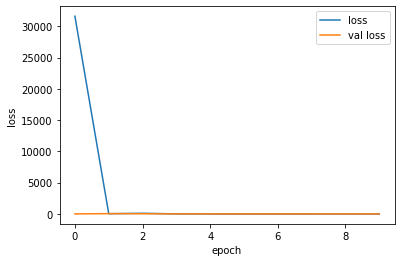

In [11]:
plt.figure(2111)
plt.plot(train_history.history['loss'], label = 'loss')
plt.plot(train_history.history['val_loss'], label = 'val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [12]:
save_mlp(mlp, '../test/model/trained_mlp')
mlp = load_mlp('../test/model/trained_mlp')

2022-04-19 02:55:40.670810: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../test/model/trained_mlp/assets
Model saved at../test/model/trained_mlp


In [13]:
mlp_pred = mlp.predict(param_test)
pk_pred = unscale(mlp_pred, scaler)

Text(0, 0.5, 'Pk')

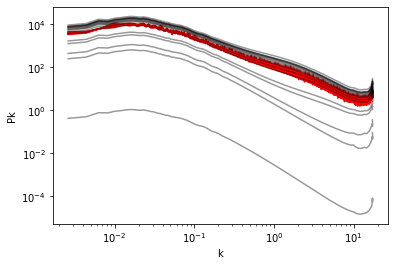

In [14]:
plt.figure(1)
plt.plot(k, pk_pred.T, 'r', alpha=0.5)
plt.plot(k, unscale(pk_test, scaler).T, 'k', alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Pk')

## explainers 

In [15]:
## local SHAP model
## global ALE model

In [16]:
from emulator_utils.explainer import shap_estimate
from emulator_utils.explainer import plot_shap_summary_single, plot_shap_summary_multiple
from emulator_utils.explainer import plot_shap_force_single, plot_shap_force_multiple

In [17]:
# import alibi
# from alibi.explainers import KernelShap
# from alibi.explainers import IntegratedGradients
# from alibi.explainers import ALE
# from alibi.explainers import plot_ale

# import shap

# def shap_estimate(model, training_data, test_data, input_names, output_names):  
#     predictor = model.predict
#     explainer = shap.KernelExplainer(predictor, training_data, features = input_names, out_names = output_names)
#     shap_values = explainer.shap_values(test_data)
#     expected_values = explainer.expected_value

#     return explainer, shap_values, expected_values

# def plot_shap_summary_single(shap_values_single, test_data, input_names, plot_type):   
#     p1 = shap.summary_plot(shap_values_single, test_data, feature_names = input_names, plot_type=plot_type)

    
# def plot_shap_summary_multiple(shap_values, test_data, input_names, plot_type):
#     p2 = shap.summary_plot(shap_values, test_data, feature_names = input_names, plot_type=plot_type)


# def plot_shap_force_single(expected_values, shap_values, input_names, output_names, out_id, test_id):
#     # predictor = model.predict
#     # explainer = shap.KernelExplainer(predictor, training_data, features = input_names, out_names = output_names)
#     p3 = shap.force_plot(expected_values[out_id], shap_values[out_id][test_id], feature_names = input_names, out_names = output_names[out_id])
#     return p3

# def plot_shap_force_multiple(expected_values, shap_values, input_names, output_names, out_id):
#     # predictor = model.predict
#     # explainer = shap.KernelExplainer(predictor, training_data, features = input_names, out_names = output_names)
#     # out_id = 0                                                                                                                                   
#     p4 = shap.force_plot(explainer.expected_value[out_id], shap_values[out_id], feature_names = input_names, out_names = output_names[out_id])  
#     return p4

In [18]:
explainer, shap_values, expected_values = shap_estimate(mlp, param_train, param_test, ['redshift'], ['pk'])

  0%|          | 0/16 [00:00<?, ?it/s]

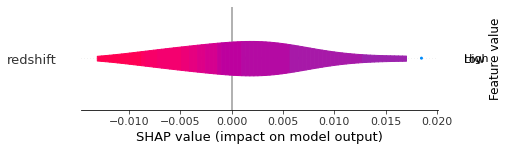

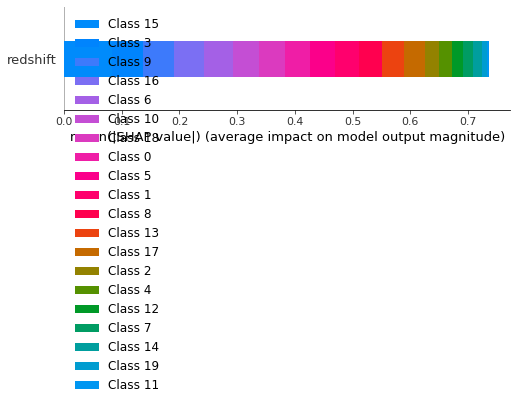

In [19]:
output_indx = 100  ## k-bin value
plot_shap_summary_single(shap_values[output_indx], param_test, ['redshift'], plot_type='violin')
plot_shap_summary_multiple(shap_values[:4000:200], param_test, ['redshift'], plot_type='bar')

In [20]:
plot_shap_force_multiple(expected_values, shap_values, ['redshift'], ['pk'], 0)

In [21]:
plot_shap_force_single(expected_values, shap_values, ['redshift'], ['pk'], 0, 11)